In [1]:
import matplotlib
import torch
from tqdm import tqdm
import os
import numpy as np
from torch.utils.data import Dataset
from torch.nn import functional as Fn
import torchvision
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat

# Load your model, data loaders and transforms here :

In [ ]:
data_path='../Datasets/market'
dataset_train = MarketDataset(data_path, mode='train',transform=transform_test)
dataset_val = MarketDataset(data_path, mode='query',transform=transform_test)
dataset_gal = MarketDataset(data_path, mode='gallery',transform=transform_test)
num_cls = 751
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=32, shuffle=False, num_workers=8)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=32, shuffle=False, num_workers=8)
gal_loader = torch.utils.data.DataLoader(dataset=dataset_gal, batch_size=32, shuffle=False, num_workers=8)
weights = ResNet50_Weights.DEFAULT
basenet = resnet50(weights=weights)
basenet.fc = torch.nn.Identity()
net = basenet
# resume = 'path to your model'
# net.load_state_dict(torch.load(resume), False)
# print(f'model loaded from {resume}')
device = 'cuda:0'
net = net.to(device)

import torchvision.transforms.v2 as transforms
image_size = (288,288//2)
transform_test = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToDtype(torch.float32, scale=True)
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# extraction function 
#Change it to fir on your model's code

In [2]:
# Your test datasets ( query and gallery) should return input images, identity and camera label: (Img: Tensor, Y: int, C: int ) 
def getFeats(net, loader):
    net = net.eval()
    img_iter = tqdm(enumerate(loader),  total=len(loader), desc='Collecting features', ncols=0)
    C, Y, Feat, = [],[],[],[]
    H, W = 0,0
    net.eval()
    with torch.no_grad():
        for i, (Xs, ys, cs) in img_iter:
            batch_size, _, H, W = Xs.shape
            feats = net(Xs.to(device))
            Y.append(ys)
            C.append(cs)
            Feat.append(feats.detach().cpu())
    N = len(indices)
    return torch.cat(Feat, dim=0), torch.cat(Y, dim=0), torch.cat(C, dim=0)

# extract the query and gallery features if you have model

In [ ]:
Feat_q, Y_q, C_q = getFeats(net, query_loader)
Feat_g, Y_g, C_g = getFeats(net, gallery_loader)

# Or loading from disk
#you can also load the features from disk. I mean instaed of extracting them here, you can save them on disk in DNNClassifier and load them here:

In [10]:
"""in DNNClassifire:"""
# torch.save(Y, save_dir + '/y_q.pt')
# torch.save(Feats, save_dir + '/feats_q.pt')
# torch.save(C, save_dir + '/c_q.pt')
save_dir='./results/temp/test_feat/'
Y_q = torch.load(save_dir + '/y_q.pt').numpy()
C_q = torch.load(save_dir + '/c_q.pt').numpy()
Feat_q = torch.load(save_dir + '/feats_q.pt')

Y_g = torch.load(save_dir + '/y_g.pt').numpy()
C_g = torch.load(save_dir + '/c_g.pt').numpy()
Feat_g = torch.load(save_dir + '/feats_g.pt')


/tmp/ipykernel_934384/3624808997.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y_q = torch.load(save_dir + '/y_q.pt').numpy()
/tmp/ipykernel_934384/3624808997.py:7: Fu

# Measuring mAP and Rank-k on features:

In [14]:
#check the mAP and CMC:
print("mAP: ", get_mAP(Feat_q, Y_q, C_q, Feat_g, Y_g, C_g))
print("CMC:", get_cmc(Feat_q, Y_q, C_q, Feat_g, Y_g, C_g))

mAP:  0.4419580853468703
CMC: [0.61490499 0.75148456 0.80967933 0.84976247 0.87410926 0.88895487
 0.90231591 0.9141924  0.92339667 0.92874109 0.93408551 0.94061758
 0.94447743 0.94893112 0.95219715 0.95397862 0.95546318 0.95694774
 0.95872922 0.96021378]


# Faithfullness of N most activated feaures:

In [15]:
def measure_FaithfulnessReID(Feat_q, Y_q, C_q, Feat_g, Y_g,C_g, N=10):
    s = 0
    sortQ = Feat_q.argsort(dim=-1, descending=True)
    sortG = Feat_g.argsort(dim=-1, descending=True)
    acc = torch.zeros(N)
    for i in range(N):
        print("iter:", i)
        A_q = Feat_q.clone()
        A_g = Feat_g.clone()
        A_q[torch.arange(len(Y_q))[:,None], sortQ[:, 0:i]] = 0
        A_g[torch.arange(len(Y_g))[:,None], sortG[:, 0:i]] = 0
        acc[i] = get_mAP(A_q, Y_q, C_q, A_g, Y_g, C_g, mix_type=1) # or get_mAP(...)
    return acc


In [48]:
acc

tensor([0.3627, 0.3145, 0.2772, 0.2432, 0.2120, 0.1846, 0.1614, 0.1402, 0.1224,
        0.1062])

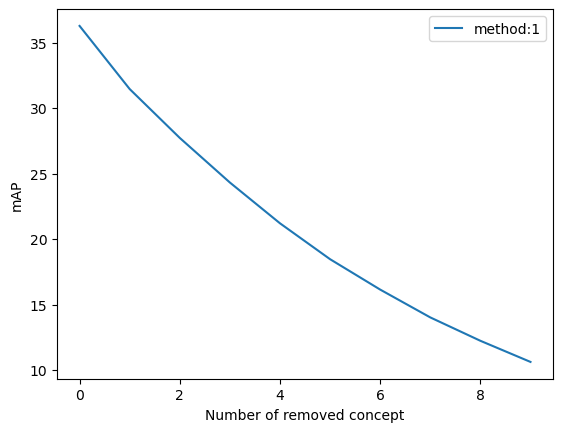

In [17]:
acc = measure_FaithfulnessReID(Feat_q, Y_q, C_q, Feat_g, Y_g, C_g)
fait={}
fait['method:1'] = acc*100
# fait['method:2'] = acc2

for name in fait:
    plt.plot(fait[name], label=name)

plt.legend(loc="upper right")
plt.xlabel("Number of removed concept")
plt.ylabel("mAP")
plt.show()

# Stability

In [37]:
def measure_Stability(feat, Y):
    mean , std = 0,0
    for yy in np.unique(Y):
        yi = (Y == yy).nonzero()[0]
    #     print(c, len(yi))
        F_Y = Fn.normalize(feat[yi].reshape(len(yi),-1))
        SS = torch.einsum('n d, b d -> n b', F_Y, F_Y)
        mean += (SS.mean() * len(yi)/len(Y))
        std += (SS.std() * len(yi)/len(Y))

        
    result = torch.Tensor([mean, std])
    return result
    


In [47]:
print("Query Stability: ", measure_Stability(Feat_q, Y_q))
print("Gallery Stability: ", measure_Stability(Feat_g, Y_g))

Query Stability:  tensor([0.5853, 0.2357])
Gallery Stability:  tensor([0.4384, 0.1339])


# Sparsness:

In [44]:
def measure_Sparseness(feats):
    sparseness = []
    for c in feats:
        uniform = torch.ones_like(c) / c.shape[-1]
        sparseness.append(1 - Fn.cosine_similarity(c.abs(), uniform, dim=-1))
    sparseness = torch.Tensor(sparseness)
    sp_mean = sparseness.mean()
    sp_std = sparseness.std() 
    return torch.Tensor([sp_mean, sp_std])

In [46]:
print("Query Sparsness: ", measure_Sparseness(Feat_q))
print("Gallery Sparsness: ", measure_Sparseness(Feat_g))

Query Sparsness:  tensor([0.8573, 0.0050])
Gallery Sparsness:  tensor([0.8586, 0.0062])


In [12]:
def pairwise_cosine(Q, G):
    Q, G = Fn.normalize(Q, dim=1), Fn.normalize(G, dim=1)
    dist_mat = (-torch.einsum('b d, n d -> b n', Q, G)).numpy()
    sorted_indices = np.argsort(dist_mat, axis=1)
    return sorted_indices

def get_unique(array):
    _, idx = np.unique(array, return_index=True)
    return array[np.sort(idx)]


def get_cmc(query_feats, query_ids, query_cam_ids, gallery_feats, gallery_ids, gallery_cam_ids, mix_type=1):
    sorted_indices = pairwise_cosine(query_feats, gallery_feats)
    gallery_unique_count = get_unique(gallery_ids).shape[0]
    match_counter = np.zeros((gallery_unique_count,))

    result = gallery_ids[sorted_indices]
    cam_locations_result = gallery_cam_ids[sorted_indices]
#     modal_result = gallery_modal[sorted_indices]

    valid_probe_sample_count = 0

    for probe_index in range(sorted_indices.shape[0]):
        # remove gallery samples from the same camera of the probe
        result_i = result[probe_index, :]
        # result_i[np.equal(cam_locations_result[probe_index], query_cam_ids[probe_index])] = -1
        if mix_type == 1:
            mask = cam_locations_result[probe_index, :] == query_cam_ids[probe_index]
        else:
            mask = np.zeros_like(result[probe_index]).astype(bool)

        result_i[mask] = -1

        # remove the -1 entries from the label result
        result_i = np.array([i for i in result_i if i != -1])

        # remove duplicated id in "stable" manner
        result_i_unique = get_unique(result_i)

        # match for probe i
        match_i = np.equal(result_i_unique, query_ids[probe_index])

        if np.sum(match_i) != 0:  # if there is true matching in gallery
            if match_i.shape[0] == match_counter.shape[0]:
                valid_probe_sample_count += 1
                match_counter += match_i

    rank = match_counter / valid_probe_sample_count
    cmc = np.cumsum(rank)
    return cmc[0:20]

def get_mAP(query_feats, query_ids, query_cam_ids, gallery_feats, gallery_ids, gallery_cam_ids, mix_type=0):
    sorted_indices = pairwise_cosine(query_feats, gallery_feats)
    result = gallery_ids[sorted_indices]
    cam_locations_result = gallery_cam_ids[sorted_indices]

    valid_probe_sample_count = 0
    avg_precision_sum = 0

    for probe_index in range(sorted_indices.shape[0]):
        # remove gallery samples from the same camera of the probe
        result_i = result[probe_index, :]
        if mix_type == 1:
            mask = cam_locations_result[probe_index, :] == query_cam_ids[probe_index]
        else:
            mask = np.zeros_like(result[probe_index]).astype(bool)

        result_i[mask] = -1

        # remove the -1 entries from the label result
        result_i = np.array([i for i in result_i if i != -1])

        # match for probe i
        match_i = result_i == query_ids[probe_index]
        true_match_count = np.sum(match_i)

        if true_match_count != 0:  # if there is true matching in gallery
            valid_probe_sample_count += 1
            true_match_rank = np.where(match_i)[0]

            ap = np.mean(np.arange(1, true_match_count + 1) / (true_match_rank + 1))
            avg_precision_sum += ap

    mAP = avg_precision_sum / valid_probe_sample_count
    return mAP

